## 👥 Alunos
- **JULIA ALANNE SILVINO DOS SANTOS**  
- **PABLO DURKHEIM FERNANDES DO NASCIMENTO**


Disciplina: PROJETO DE SISTEMAS BASEADOS EM APRENDIZADO DE MÁQUINA

---

## 📝 Descrição do Projeto
Este projeto implementa uma **Rede Neural Convolucional (CNN)** do tipo *LeNet-like* para a classificação do dataset **Fashion-MNIST**.

O objetivo principal é:

- Seguir a estrutura modular apresentada em sala de aula pelo professor  
  **Featurizer → Classifier**
- Demonstrar a extração de características em todas as camadas
- Utilizar **Hooks** para visualização das ativações

---

## 📦 Dataset Escolhido
- **Dataset:** `zalandoresearch/fashion-mnist` (via `torchvision.datasets`)  
- **Classes:** 10 categorias de vestuário  
- **Resolução Original:** `28 × 28` pixels (tons de cinza, 1 canal)

---

## 🧠 Adaptação da Arquitetura para 28×28

Embora o diagrama didático do professor utilizasse entrada de `10×10`, optamos por manter a dimensão **original do dataset (28×28)** para maximizar a acurácia.

A arquitetura segue a forma **LeNet-like**:

**CONV → RELU → MAXPOOL → FC → RELU → FC**

---

## 📐 Cálculo das Dimensões

A fórmula geral para o cálculo do tamanho de saída de uma convolução é:

$$
\text{out} = \left\lfloor \frac{n + 2p - k}{s} \right\rfloor + 1
$$

Onde:

- 𝑛 é o tamanho da entrada

- 𝑝 é o padding

- 𝑘 é o tamanho do kernel

- 𝑠 é o stride

---

### **Input:** $1 \times 28 \times 28$


---

### **conv1**
- Kernel: `5 × 5`  
- Padding: `0`  
- Stride: `1`  

Aplicando a fórmula:

$$
\text{out} = \left\lfloor \frac{28 + 2(0) - 5}{1} \right\rfloor + 1
           = 23 + 1
           = 24
$$

- **Output:** `1 × 24 × 24`

---

### **maxp1**
- Entrada: 24 × 24  
- Kernel: 2  
- Stride: 2  

$$
\text{out} = \left\lfloor \frac{24 + 0 - 2}{2} \right\rfloor + 1 = 12
$$


- **Output:** `1 × 12 × 12`

---

### **Flatten**
$$
1 × 12 × 12 = \mathbf{144} \text{ features}
$$

---

### **fc1**
- A entrada da primeira camada densa é (`in_features`) 144


## 💻 Código do Projeto

### 0. Importação de Bibliotecas


In [8]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

### 1. Arquitetura

Define a classe central **Architecture**, a mesma que o professor usou no notebook Week06 só que adaptada. Responsável por gerenciar o modelo, o processo de treinamento, o cálculo de **Loss** e **Accuracy**, além das funções de **Hooks** e da visualização dos *Feature Maps*.


In [9]:
class Architecture(object):
    """
    Classe para encapsular a arquitetura, treinamento, hooks e visualização.
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.total_epochs = 0
        self.train_step_fn = self._make_train_step_fn()
        self.val_step_fn = self._make_val_step_fn()
        self.handles = {}
        self.visualization = {}

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        def perform_train_step_fn(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step_fn(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        data_loader = self.val_loader if validation else self.train_loader
        step_fn = self.val_step_fn if validation else self.train_step_fn
        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def _calculate_accuracy(self, data_loader):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            with torch.no_grad():
                yhat = self.model(x_batch)
                predicted = torch.argmax(yhat, dim=1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)
        return total_correct / total_samples

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)
        print(f"Starting training on {self.device} for {n_epochs} epochs...")
        for epoch in range(n_epochs):
            self.total_epochs += 1

            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            accuracy = self._calculate_accuracy(self.train_loader)
            self.accuracies.append(accuracy)
            val_accuracy = self._calculate_accuracy(self.val_loader)
            self.val_accuracies.append(val_accuracy)

            print(f"Epoch {self.total_epochs}/{n_epochs} - Loss: {loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {accuracy:.4f} - Val Acc: {val_accuracy:.4f}")
        print("Training finished.")

    def predict(self, x):
        self.model.eval()
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        ax1.plot(self.losses, label='Training Loss', c='b')
        ax1.plot(self.val_losses, label='Validation Loss', c='r')
        ax1.set_yscale('log')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (Log Scale)')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()

        ax2.plot(self.accuracies, label='Training Accuracy', c='b')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', c='r')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_ylim(0, 1)
        ax2.legend()

        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        n_images = len(axs)
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])

        predicted = None
        if x.ndim == 2:
            if yhat is not None:
                predicted = np.argmax(x, axis=1)

        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)

            shp = np.atleast_2d(image).shape
            ax.set_ylabel(f'{layer_name}\n{shp[0]}x{shp[1]}', rotation=0, labelpad=40)

            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if predicted is None else f'\nPred: {predicted[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)

            ax.set_xticks([])
            ax.set_yticks([])

            if image.ndim == 3 and image.shape[0] == 1:
                ax.imshow(image.squeeze(), cmap='gray', vmin=minv, vmax=maxv)
            elif x.ndim == 2:
                 # Plot vetorial horizontal
                 ax.imshow(np.atleast_2d(image), cmap='gray', vmin=minv, vmax=maxv, aspect='auto')
            elif image.ndim == 2:
                 ax.imshow(image, cmap='gray', vmin=minv, vmax=maxv)
            else:
                 ax.imshow(np.atleast_2d(image), cmap='gray', vmin=minv, vmax=maxv, aspect='auto')
        return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        self.visualization = {}
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            def hook_fn(layer, inputs, outputs):
                name = layer_names[layer]
                values = outputs.detach().cpu().numpy()
                if self.visualization.get(name) is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            if name in layers_to_hook:
                self.visualization[name] = None
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        for handle in self.handles.values():
            handle.remove()
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)

        layer_order_map = {name: i for i, name in enumerate(layers_to_hook)}
        layers.sort(key=lambda x: layer_order_map.get(x, float('inf')))

        shapes = [self.visualization[layer].shape for layer in layers]

        total_rows = 0
        n_rows = []
        for shape in shapes:
            if len(shape) == 4:
                n_rows.append(shape[1])
                total_rows += shape[1]
            elif len(shape) == 2:
                n_rows.append(1)
                total_rows += 1
            else:
                 n_rows.append(1)
                 total_rows += 1

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows),
                                squeeze=False)
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        row = 0
        for i, layer in enumerate(layers):
            output = self.visualization[layer]
            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                if is_vector:
                     output_slice = output
                     layer_label = layers[i]
                elif output.ndim == 4:
                     output_slice = output[:, j]
                     layer_label = f'{layers[i]} | fil#{j}'
                else:
                     output_slice = output[:, j]
                     layer_label = f'{layers[i]} | feat#{j}'

                Architecture._visualize_tensors(
                    axes[row, :],
                    output_slice,
                    y,
                    yhat,
                    layer_name=layer_label,
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig


# Funções auxiliares mantidas inalteradas (TransformedTensorDataset, index_splitter, make_balanced_sampler)
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
            if isinstance(x, np.ndarray):
                x = T.ToImage()(x)
                x = T.ToDtype(torch.float32, scale=True)(x)

            x = self.transform(x)

        return x, self.y[index]

    def __len__(self):
        return len(self.x)

def index_splitter(n, splits, seed=13):
    splits_tensor = torch.as_tensor(splits)
    total = splits_tensor.sum().float()
    if not total.isclose(torch.ones(1)[0]):
        splits_tensor = splits_tensor / total

    torch.manual_seed(seed)
    idx = torch.arange(n)
    lengths = [int(p * n) for p in splits_tensor]
    lengths[-1] = n - sum(lengths[:-1])

    train_idx, val_idx = random_split(idx, lengths)

    return train_idx.indices, val_idx.indices

def make_balanced_sampler(y):
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler


### 2. Preparação dos Dados (Fashion-MNNIST 28×28)

Este bloco carrega o dataset **Fashion-MNIST**, define as transformações necessárias (apenas **normalização**, sem redimensionamento) e cria os **DataLoaders** para treino e validação.


In [10]:
# ==============================================================================
# 2. Preparação dos Dados (Fashion-MNIST)
# ==============================================================================
print("--- 1. Preparação dos Dados ---")
FASHION_MNIST_MEAN = (0.5,)
FASHION_MNIST_STD = (0.5,)
# INPUT PASSARÁ A SER 28x28
IMG_SIZE = 28

train_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
val_transforms = T.Compose([
    T.Resize(IMG_SIZE, antialias=True), T.ToTensor(), T.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)
])
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transforms)
full_val_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=val_transforms)
y_train_tensor = full_train_dataset.targets
sampler = make_balanced_sampler(y_train_tensor)
BATCH_SIZE = 64
train_loader = DataLoader(dataset=full_train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=full_val_dataset, batch_size=BATCH_SIZE)
print("DataLoaders configurados.")

--- 1. Preparação dos Dados ---
DataLoaders configurados.


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### 3. Definição do modelo

Este bloco define a arquitetura **LeNet-like**, adaptando o `kernel_size` da `conv1` para **$5 \times 5$** e ajustando o `in_features` da `fc1` para **144**, conforme o cálculo baseado no input **$28 \times 28$**.


In [11]:
# ==============================================================================
# 3. Definição da Arquitetura CNN (Modelo Otimizado LeNet-like 28x28)
# ==============================================================================
print("\n--- 2. Configuração do Modelo Otimizado (LeNet-like 28x28) ---")
n_channels = 1
# Novo cálculo: 1 canal * 12x12 = 144 features
INPUT_SIZE = 144
OUTPUT_CLASSES = 10

torch.manual_seed(17)
model_cnn1 = nn.Sequential()

# Featurizer
# conv1: 1@28x28 -> 1@24x24 (kernel=5, 28-5+1=24)
model_cnn1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=5))
model_cnn1.add_module('relu1', nn.ReLU())
# maxp1: 1@24x24 -> 1@12x12 (kernel=2, 24/2=12)
model_cnn1.add_module('maxp1', nn.MaxPool2d(kernel_size=2))
# Flattening: 1@12x12 -> 144
model_cnn1.add_module('flatten', nn.Flatten())

# Classifier
# fc1: in=144, out=10
model_cnn1.add_module('fc1', nn.Linear(in_features=INPUT_SIZE, out_features=10))
model_cnn1.add_module('relu2', nn.ReLU())
# fc2: in=10, out=10
model_cnn1.add_module('fc2', nn.Linear(in_features=10, out_features=OUTPUT_CLASSES))

multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn1 = optim.SGD(model_cnn1.parameters(), lr=0.01)

arch_cnn1 = Architecture(model_cnn1, multi_loss_fn, optimizer_cnn1)
arch_cnn1.set_loaders(train_loader, val_loader)
print(f"Modelo CNN criado. Arquitetura: {arch_cnn1.model.to(arch_cnn1.device)}")



--- 2. Configuração do Modelo Otimizado (LeNet-like 28x28) ---
Modelo CNN criado. Arquitetura: Sequential(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=144, out_features=10, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)


### 4. Treinamento e Log de Métricas (Loss e Accuracy)



In [12]:
# ==============================================================================
# 4. Treinamento
# ==============================================================================
print("\n--- 3. Treinamento ---")

N_EPOCHS = 30
arch_cnn1.train(N_EPOCHS)


--- 3. Treinamento ---
Starting training on cpu for 30 epochs...
Epoch 1/30 - Loss: 1.0193 - Val Loss: 0.7195 - Acc: 0.7379 - Val Acc: 0.7288
Epoch 2/30 - Loss: 0.6724 - Val Loss: 0.6479 - Acc: 0.7662 - Val Acc: 0.7535
Epoch 3/30 - Loss: 0.6239 - Val Loss: 0.6652 - Acc: 0.7612 - Val Acc: 0.7491
Epoch 4/30 - Loss: 0.5977 - Val Loss: 0.6384 - Acc: 0.7714 - Val Acc: 0.7639
Epoch 5/30 - Loss: 0.5836 - Val Loss: 0.6077 - Acc: 0.7826 - Val Acc: 0.7713
Epoch 6/30 - Loss: 0.5714 - Val Loss: 0.5807 - Acc: 0.7967 - Val Acc: 0.7817
Epoch 7/30 - Loss: 0.5516 - Val Loss: 0.5970 - Acc: 0.7756 - Val Acc: 0.7657
Epoch 8/30 - Loss: 0.5533 - Val Loss: 0.5675 - Acc: 0.7972 - Val Acc: 0.7864
Epoch 9/30 - Loss: 0.5365 - Val Loss: 0.5868 - Acc: 0.7941 - Val Acc: 0.7825
Epoch 10/30 - Loss: 0.5301 - Val Loss: 0.5875 - Acc: 0.7939 - Val Acc: 0.7778
Epoch 11/30 - Loss: 0.5215 - Val Loss: 0.5692 - Acc: 0.8030 - Val Acc: 0.7880
Epoch 12/30 - Loss: 0.5118 - Val Loss: 0.5375 - Acc: 0.8132 - Val Acc: 0.7981
Epoch 1

### 5. Visualização (Hooks, Feature Maps, Logits e Gráficos de Métricas)




--- 4. Coleta de Ativações (Hooks) ---
Ativações capturadas.

--- 4.1. Gráficos de Loss e Accuracy ---


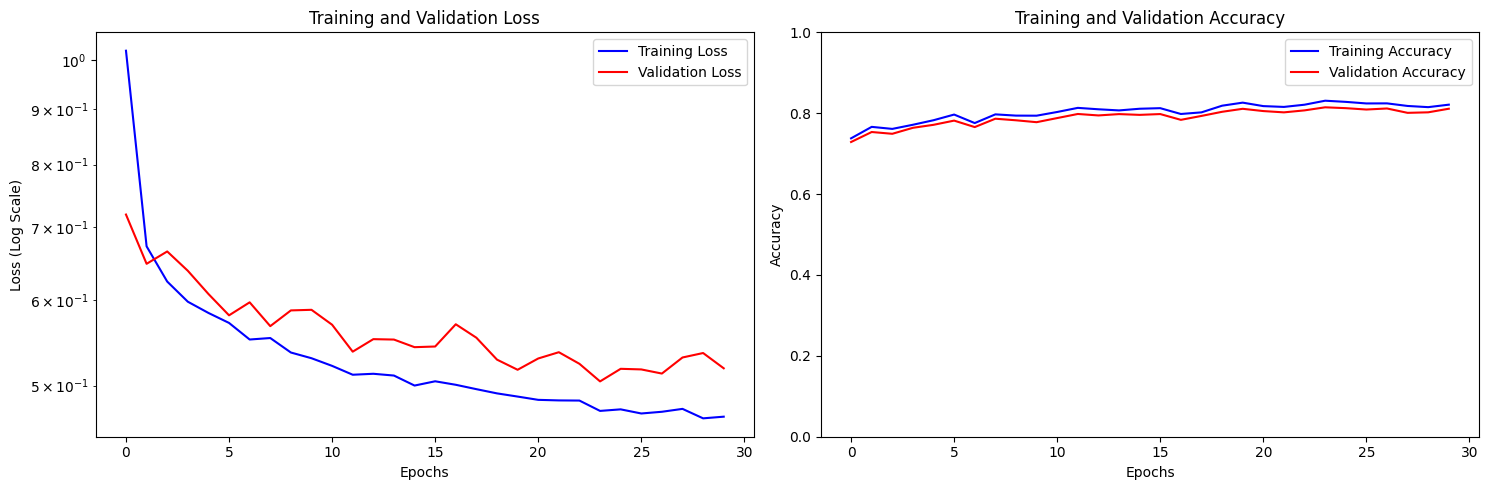


--- 4.2. Visualização dos Feature Maps e Ativações (Hooks) ---


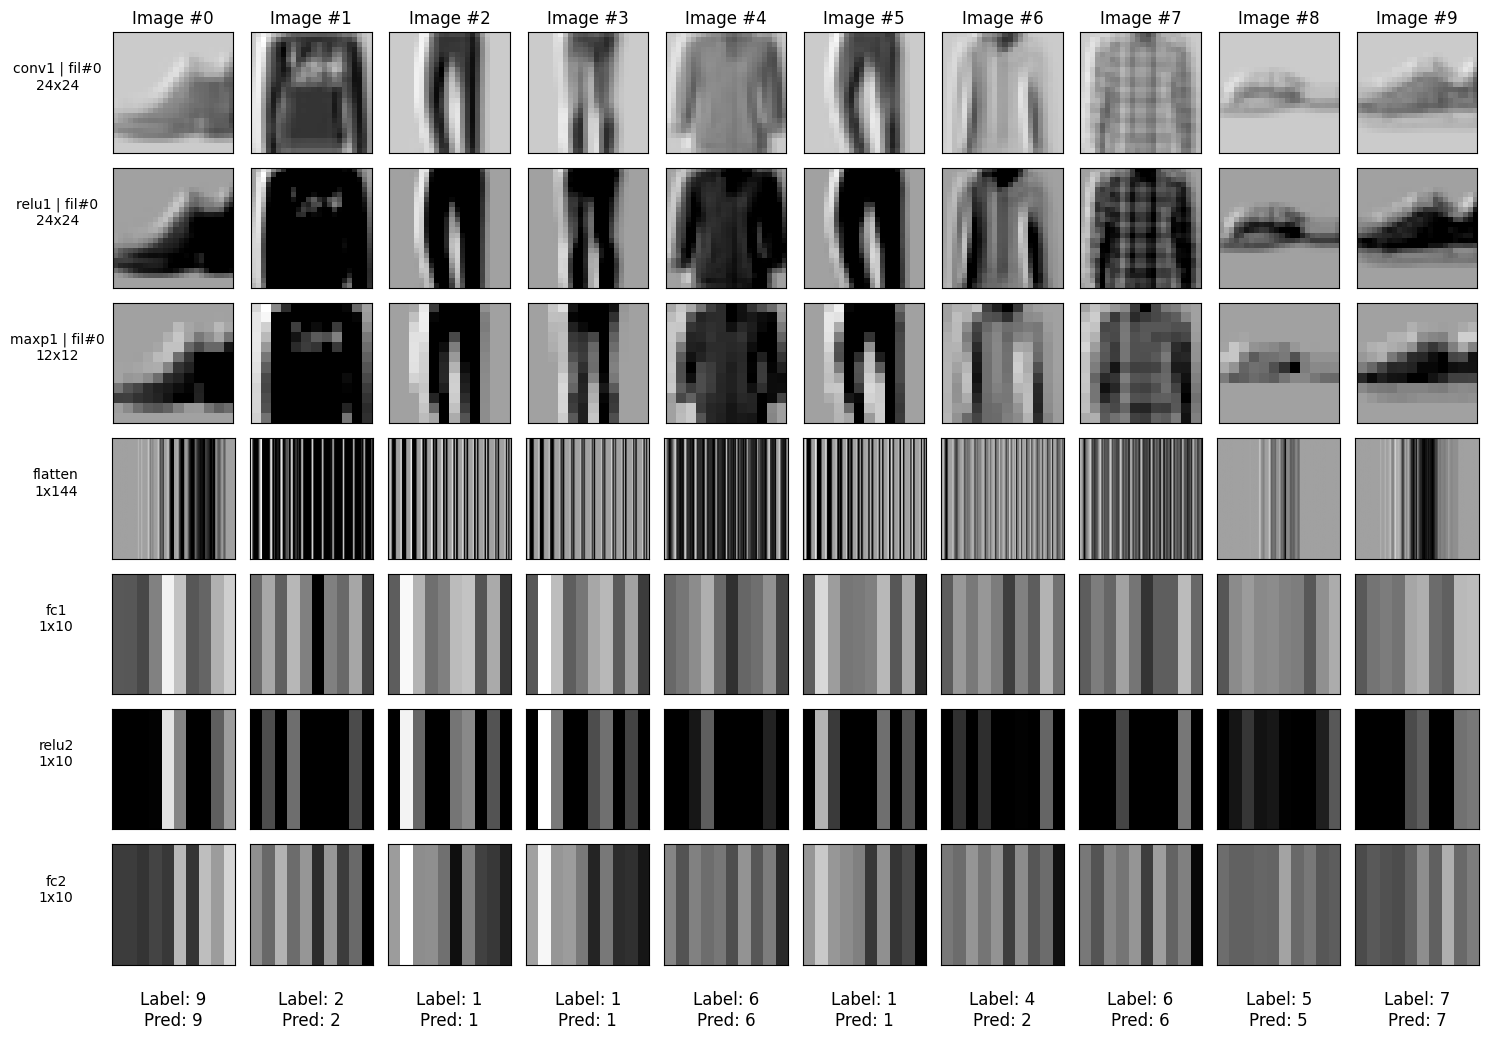


--- 4.3. Tabela de Logits (Saída Final da Rede) ---
Logits para as primeiras 10 imagens do batch (antes do Softmax):


,Logit C0,Logit C1,Logit C2,Logit C3,Logit C4,Logit C5,Logit C6,Logit C7,Logit C8,Logit C9,Label Real,Predição
Img #0,-4.55,-4.67,-5.55,-3.75,-5.11,+9.11,-5.55,+9.78,+6.06,+12.33,9,9
Img #1,+4.55,+0.18,+8.71,+0.63,+5.37,-6.37,+5.42,-4.61,+0.40,-11.42,2,2
Img #2,+6.03,+17.11,+4.31,+4.62,+1.16,-9.69,+3.18,-4.10,-5.16,-8.05,1,1
Img #3,+6.55,+16.17,+5.40,+6.05,+2.26,-7.29,+2.06,-6.33,-5.90,-8.90,1,1
Img #4,+3.49,-2.15,+3.06,+0.79,+1.86,-2.67,+5.04,-1.72,+2.49,-6.69,6,6
Img #5,+5.33,+10.99,+5.44,+4.28,+2.93,-4.98,+4.65,-5.49,-3.21,-11.07,1,1
Img #6,+1.98,+0.63,+5.26,+1.66,+5.16,-4.43,+4.21,-1.83,+0.65,-9.53,4,2
Img #7,+1.96,-1.96,+3.71,+1.67,+5.20,-4.40,+6.23,-0.30,+2.93,-10.58,6,6
Img #8,+0.76,-0.57,-0.50,+0.04,-0.21,+6.88,+0.42,+2.01,-1.63,-0.98,5,5
Img #9,-3.03,-1.33,-2.23,-2.92,-0.41,+4.48,-0.68,+8.18,+0.48,+2.59,7,7


In [14]:

# ==============================================================================
# 5. Visualização (Hooks e Métricas)
# ==============================================================================
print("\n--- 4. Coleta de Ativações (Hooks) ---")

layers_to_hook = ['conv1', 'relu1', 'maxp1', 'flatten', 'fc1', 'relu2', 'fc2']
arch_cnn1.attach_hooks(layers_to_hook)

images_batch, labels_batch = next(iter(val_loader))

with torch.no_grad():
     logits_tensor = arch_cnn1.model(images_batch.to(arch_cnn1.device))
     logits = logits_tensor.detach().cpu().numpy()
     predicted_labels = np.argmax(logits, axis=1)

arch_cnn1.remove_hooks()
print("Ativações capturadas.")


# --- 5.1. Gráficos de Perda E ACURÁCIA ---
print("\n--- 4.1. Gráficos de Loss e Accuracy ---")
fig_metrics = arch_cnn1.plot_metrics()
plt.show(fig_metrics)


# --- 5.2. Visualização dos Feature Maps (Hooks) ---
print("\n--- 4.2. Visualização dos Feature Maps e Ativações (Hooks) ---")
fig_maps = arch_cnn1.visualize_outputs(layers_to_hook, n_images=10, y=labels_batch.numpy(), yhat=predicted_labels)
plt.show(fig_maps)


# --- 5.3. Logits ---
print("\n--- 4.3. Tabela de Logits (Saída Final da Rede) ---")
n_show = 10
logits_subset = logits[:n_show]
predicted_subset = predicted_labels[:n_show]
labels_subset = labels_batch[:n_show].numpy()

data = {f"Logit C{i}": [f"{l:+.2f}" for l in logits_subset[:, i]] for i in range(OUTPUT_CLASSES)}
data['Label Real'] = labels_subset
data['Predição'] = predicted_subset
df_logits = pd.DataFrame(data, index=[f"Img #{i}" for i in range(n_show)])
print("Logits para as primeiras 10 imagens do batch (antes do Softmax):")
display(df_logits)


## 📈 Análise dos Resultados e Desempenho do Modelo

No geral, podemos afirmar que tivemos um bom resultado. O gráfico do Loss nos mostra um acompanhamento das funções de perda (treino e validação) fugindo da "boca do jacaré", embora a acurácia se mantenha por volta de 80% nas predições plotadas, foram 9 acertos de 10, o que é bastante significativo, fazendo apenas com 30 épocas, em outros testes com 50 épocas ou mais foram 100% de acertos. No github onde se encontra o dataset da Fashion-MNIST também é disponibilizado o benchmark, o melhor desempenho teve 0.897 de acurácia, o nosso ficou por volta de 0.800, o que indica que ainda é possível melhorar.
